In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame as DF
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import scipy
import scipy.io
import mat73 # load mat as dict

# gpflow
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
from gpflow.utilities import print_summary, set_trainable, to_default_float

%matplotlib inline
plt.rcParams["figure.figsize"] = (5, 2)
plt.rcParams["font.size"] = 14

PATH = './data'
PATH_SAVE = './graphics/GPR'

plt.rcParams.update({
    "text.usetex": False})

In [2]:
df = pd.read_parquet('data/entsoe-generation-wind_units-201501_202103.parquet', engine='fastparquet')
df

,DateTime,MapCode,GenerationUnitEIC,PowerSystemResourceName,ProductionTypeName,ActualGenerationOutput,InstalledGenCapacity
0,2014-12-21 00:00:00,GB,48W000000BLLA-1K,BLLA-1,Wind Onshore,27.370,134.0
1,2014-12-21 00:00:00,GB,48W000000RREW-14,RREW-1,Wind Offshore,25.710,90.0
2,2014-12-21 00:00:00,GB,48W000000RRWW-1P,RRWW-1,Wind Offshore,0.050,90.0
3,2014-12-21 00:00:00,GB,48W00000BABAW-13,BABAW-1,Wind Onshore,8.300,52.0
4,2014-12-21 00:00:00,GB,48W00000BOWLW-1K,BOWLW-1,Wind Offshore,24.645,90.0
...,...,...,...,...,...,...,...
3959592,2021-04-11 21:00:00,BE,22W20200615C---Z,Seastar Offshore WP,Wind Offshore,39.150,252.0
3959593,2021-04-11 21:00:00,BE,22WBELWIN1500271,Belwind Phase 1,Wind Offshore,22.730,171.0
3959594,2021-04-11 21:00:00,BE,22WNORTHW150187B,Northwind,Wind Offshore,26.520,216.0
3959595,2021-04-11 21:00:00,BE,22WTHORNT150237E,Thorntonbank - C-Power - Area NE,Wind Offshore,4.880,147.6


# Methoden-Paper

## Functions

In [3]:
def GPFLOW_plot_it(X, Y, xx, m, mean, var, cov, samples, w, T=150):
    fig = plt.figure(figsize=(12, 6))
    plt.plot(X, Y, "kx", mew=2)
    plt.fill_between(xx[:, 0], mean[:, 0] - 1.96 * np.sqrt(var[:, 0]), 
                     mean[:, 0] + 1.96 * np.sqrt(var[:, 0]), color="red", alpha=0.2)
    plt.plot(xx, samples[:, :, 0].numpy().T, "C0", linewidth=0.5)
    plt.plot(xx, mean, "red", lw=2)
    #plt.ylim(-0.1, 1.1)
    #plt.xlim(100, 200)
    plt.xlabel("hours")
    plt.ylabel("demand (MWh)")
    if kernel.name not in ['sum', 'product']:
        plt.title(m.kernel.name)
    else:
        plt.title([m.kernel.kernels[i].name for i in range(len(m.kernel.kernels))])
    plt.show()
    
    print_summary(m)

    sns.heatmap(cov)
    plt.title("Covariance matrix")
    plt.show()

    a, b = T, T_horizon
    cov_small = cov[a:a+b, a:a+b]
    sns.heatmap(cov_small)
    plt.title("Covariance matrix excerpt")
    plt.show()
    
    sns.heatmap(cov + w*np.eye(len(cov)))
    plt.title("Covariance matrix + whitening")
    plt.show()
    
    L = scipy.linalg.cholesky(cov + w*np.eye(len(cov)), lower=True)
    sns.heatmap(L)
    plt.title("Lower Cholesky + whitening")
    plt.show()
    
    L_small = L[a:a+b, a:a+b]
    sns.heatmap(L_small)
    plt.title("Lower Cholesky excerpt + whitening")
    plt.show()

    plt.plot(mean)
    plt.title("mean demand")
    plt.xlabel("hours")
    plt.ylabel("demand")
    plt.show()
    
    mean_small = mean[-T_horizon:-1]
    plt.plot(mean_small)
    plt.title("mean small demand")
    plt.xlabel("hours")
    plt.ylabel("demand")
    plt.show()

In [4]:
# hide
        
def to_mat(L, mean, output_name='LoadData_new'):
    if L is not None: # if covariance matrix is not singular s.t. Cholesky decomposition exists

        # new output file
        out = dict()
        out['__header__'] = b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Fri Sep 07 13:14:25 2018'
        out['__version__'] = '1.0'
        out['__globals__'] = []
        out['Lpost'] = L
        out['mu_post'] = mean

        # save to .mat file
        scipy.io.savemat(str('data/covariance_matrices/' + output_name + '.mat'), out)

        print('Successfully stored load data!!')

    else:
        print('Sorry, no output!')
        
def to_mat_cov(L, cov, mean, output_name='LoadData_new'):
    if L is not None: # if covariance matrix is not singular s.t. Cholesky decomposition exists

        # new output file
        out = dict()
        out['__header__'] = b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Fri Sep 07 13:14:25 2018'
        out['__version__'] = '1.0'
        out['__globals__'] = []
        out['Lpost'] = L
        out['cov'] = cov
        out['mu_post'] = mean

        # save to .mat file
        scipy.io.savemat(str('data/' + output_name + '.mat'), out)

        print('Successfully stored load data!!')

    else:
        print('Sorry, no output!')

In [5]:
def run_GPR(X, Y, T_horizon, kernel, meanf):
    m = gpflow.models.GPR(data=(X, Y), kernel=kernel, mean_function=meanf)
    #set_trainable(m.likelihood.variance, 0.01)
    m.likelihood.variance.assign(0.01)
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=10))

    ## generate test points for prediction
    x_ticks = len(X)+T_horizon
    offset = 20
    xx = np.linspace(0, x_ticks, x_ticks-offset).reshape(x_ticks-offset, 1)
    mean, var = m.predict_f(xx)
    _, cov_full2 = m.predict_f(xx, full_cov=True)
    cov2 = cov_full2.numpy()[0,:,:]
    tf.random.set_seed(1)  # for reproducibility
    samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)
    
    return xx, mean, var, cov2, samples

def plot_GPR(key, xx, X, Y, d_test, mean, var, cov, samples):
    ## plot
    fig = plt.figure(figsize=(12, 6))
    plt.plot(X, Y, "kx", mew=2)
    plt.fill_between(xx[:, 0], mean[:, 0] - 1.96 * np.sqrt(var[:, 0]), 
                     mean[:, 0] + 1.96 * np.sqrt(var[:, 0]), color="r", alpha=0.2)
    plt.plot(xx, samples[:, :, 0].numpy().T, "C0", linewidth=0.5, c='y')
    plt.plot(xx, mean, "r", lw=2)
    #plt.plot(d_test, c='b')
    #plt.ylim(-0.1, 1.1)
    #plt.xlim(100, 200)
    plt.xlabel("hours", fontsize=20)
    plt.ylabel(" wind power output (MW)", fontsize=20)
    plt.title(key)
    plt.savefig('graphics/GPR/Wind_power_forecast_noSmoothing.png')
    plt.show()

In [6]:
def transform_ts(ts, T_horizon, key):
    d = ts
    day1, day2 = params[key]['days']
    scaler = MinMaxScaler([-40,40])
    d_ = d[0+24*(day1-1):24*(day2)+params[key]['offset']].reset_index(drop=True)
    d_ = DF(scaler.fit_transform(np.array(d_).reshape(-1,1)))
    d_train = d_[:-T_horizon]
    d_test = d_[-T_horizon:]
    
    return d_, d_train, d_test, scaler

def plot_ts(d, T_horizon, d_train, d_test, key):
    plt.figure(figsize=(20,5))
    plt.plot(d_train)
    plt.plot(d_test)
    idx_lst = d.index
    day_boarders = [a for a in idx_lst if a % 24==0]
    plt.vlines(day_boarders, np.min(d), np.max(d), linestyles='dashed', colors='black')
    plt.show()

In [7]:
def get_mean_var(T_horizon, mean, cov, scaler):

    m_horizon = np.array(mean[-T_horizon:])
    m = np.array(np.squeeze(scaler.inverse_transform(m_horizon)))
    C_ = cov[-T_horizon-1:-1,-T_horizon-1:-1]
    C = C_ * 0.01+ 1e-7*np.eye(len(C_))

    # cholesky decomposition
    L = None # lower triangluar matrix
    try:
        L = scipy.linalg.cholesky(C, lower=True)
    except:
        print("Covariance matrix is singular!")
        
    return m, L, C

def scaling(key, m, L, C):
    # scaling
    f = params[key]['scaling']
    m = m / f / 1
    L = L / f / 3 # * 20
    C = C / f / 3 # * 20
    
    return m, L, C

def plot_prediction(key, m, C):
    plt.figure(figsize=(10,5))
    plt.plot(m)
    plt.fill_between(list(range(len(m))), m + np.sqrt(np.diag(C)),  m - np.sqrt(np.diag(C)), alpha=0.3)
    plt.title(key)
    plt.xlabel('hours (h)')
    plt.ylabel('power output (MW)')
    plt.show()

In [22]:
def pipeline(df, T_horizon, key, kernel, PLOT_TS=False, PLOT_GPR=False, PLOT_PRED=False, SAVE=False):
    
    # extract time series
    ts = df[df['PowerSystemResourceName'] == key]['ActualGenerationOutput'].reset_index(drop=True)
    #ts = ts.rolling(params[key]['rollingWindow']).mean()
    ts = ts.rolling(5).mean()
    
    # transform ts
    ts, ts_train, ts_test, scaler = transform_ts(ts, T_horizon, key)
    X, Y = np.array([[float(a)] for a in ts_train.index]), np.array([[a] for a in ts_train[0]])
    
    # plot ts
    if PLOT_TS:
        plot_ts(ts, T_horizon, ts_train, ts_test, key)
    
    #GPR
    meanf = gpflow.mean_functions.Constant()
    xx, mean, var, cov, samples = run_GPR(X, Y, T_horizon, kernel, meanf)
    
    if PLOT_GPR:
        plot_GPR(key, xx, X, Y, ts_test, mean, var, cov, samples)
    
    # mean, variance
    m, L, C = get_mean_var(T_horizon, mean, cov, scaler)
    m, L, C = scaling(key, m, L, C)
    if PLOT_PRED:
        plot_prediction(key, m, C)
    
    # save
    if SAVE:
        i = params[key]['i']
        to_mat_cov(L, C, m, output_name='CovMatrix_volatile_'+str(T_horizon)+'_'+str(i))
    
    return  m, L, C

## Parameters

In [9]:
# kernels
def get_kernel(name):
    if key == 'BABAW-1':
        kernel = gpflow.kernels.Cosine(lengthscales=[22.3], variance=10)
        kernel = gpflow.kernels.Product([kernel, gpflow.kernels.RBF(lengthscales=[15.9], variance=100.9)])
        kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.Cosine(lengthscales=[100.33], variance=100)])
        kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.Constant()])
        
        kernel = gpflow.kernels.Cosine(lengthscales=20, variance=10)
        kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.Matern12(variance=10)])
        kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.RBF(lengthscales=15, variance=10)])
        kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.Constant()])

    elif key == 'BLLA-1' or key == 'BOWLW-1':        
        kernel = gpflow.kernels.Cosine(lengthscales=20, variance=10)
        kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.Matern12()])
        kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.RBF(lengthscales=15, variance=10)])
        kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.Constant()])

    elif key == 'Northwind':        
        kernel = gpflow.kernels.Cosine(lengthscales=20)
        kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.Matern12(variance=10)])
        kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.RBF(variance=100)])
        kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.Constant()])

    elif key == 'Belwind Phase 1':
        kernel = gpflow.kernels.Cosine(lengthscales=[20], variance=10)
        kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.Matern12(variance=10)])
        kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.RBF(variance=10)])
        kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.Constant()])

    elif key == 'Seastar Offshore WP':
        kernel = gpflow.kernels.Cosine(lengthscales=[20])
        kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.Matern12(variance=10)])
        kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.RBF(variance=10)])
        kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.Constant()])

    elif key == 'GYMRO-15':
        kernel = gpflow.kernels.Cosine()
        kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.Matern12(variance=10)])
        kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.RBF()])
        kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.Constant()])

    elif key == 'UP_BDDSLDSRDI_1':
        kernel = gpflow.kernels.Cosine(lengthscales=50)
        kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.Matern12(variance=10)])
        kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.RBF()])
        kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.Constant()])

    elif key == 'Thorntonbank - C-Power - Area NE':
        kernel = gpflow.kernels.Cosine(lengthscales=80, variance=10)
        kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.Matern12(variance=10)])
        kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.RBF(lengthscales=20, variance=100)])
        kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.Constant()])

    elif key == 'Thorntonbank - C-Power - Area SW':
        kernel = gpflow.kernels.Cosine(lengthscales=20, variance=10)
        kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.Matern12(variance=10)])
        kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.RBF(lengthscales=200, variance=10)])
        kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.Constant()])
        
    return kernel

In [10]:
params = {'BABAW-1'             : {'days' : (35, 45), 'offset' : 0, 'rollingWindow' : 10, 'scaling' : 40, 'i' : 2 }, # offset 5, rollingWindow 1 OR offset 20, rollingWindow 20
          'BLLA-1'              : {'days' : (56, 66), 'offset' : 0, 'rollingWindow' : 10, 'scaling' : 40, 'i' : 9 },
          'BOWLW-1'             : {'days' : (145, 155), 'offset' : 0, 'rollingWindow' : 10, 'scaling' : 40, 'i' : 10 },
          'Northwind'           : {'days' : (50, 60), 'offset' : 0, 'rollingWindow' : 10, 'scaling' : 40, 'i' : 1}, # offset -10
          'Belwind Phase 1'     : {'days' : (93, 103), 'offset' : 0, 'rollingWindow' : 10, 'scaling' : 40, 'i' : 3},
          'Seastar Offshore WP' : {'days' : (67, 77), 'offset' : 0, 'rollingWindow' : 10, 'scaling' : 40, 'i' : 4},
          'GYMRO-15'            : {'days' : (71, 81), 'offset' : 0, 'rollingWindow' : 10, 'scaling' : 40, 'i' : 5},
          'UP_BDDSLDSRDI_1'     : {'days' : (153,169), 'offset' : 0, 'rollingWindow' : 10, 'scaling' : 40, 'i' : 6},
          'Thorntonbank - C-Power - Area NE' : {'days' : (162, 172), 'offset' : 0, 'rollingWindow' : 10, 'scaling' : 40, 'i' : 7},
          'Thorntonbank - C-Power - Area SW' : {'days' : (258, 268), 'offset' : 0, 'rollingWindow' : 10, 'scaling' : 40, 'i' : 8}}

In [11]:
# kernel (same for all)
kernel = gpflow.kernels.Cosine(lengthscales=20, variance=10)
#kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.Matern12()])
kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.RBF()])
kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.Constant()])

## GPR

### Single

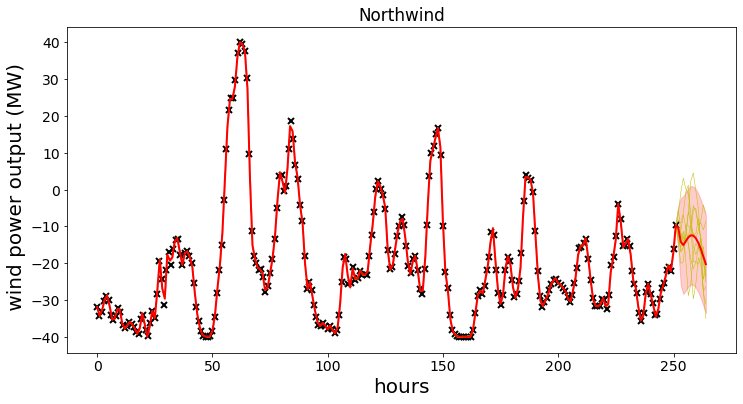

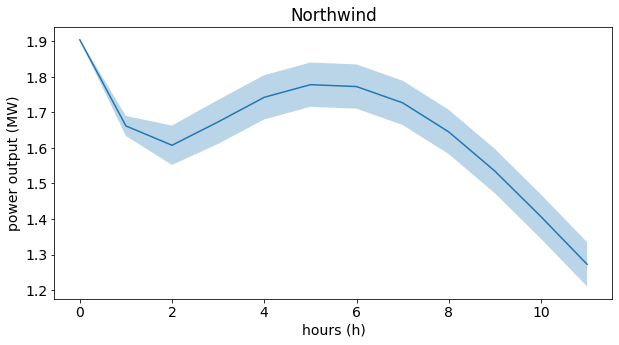

Successfully stored load data!!


In [17]:
key = 'BLLA-1' # wind generation
#key = 'BABAW-1'
key = 'BOWLW-1'
key = 'Northwind'
#key = 'Belwind Phase 1' # load
#key = 'Seastar Offshore WP' # load
#key = 'GYMRO-15'
#key = 'UP_BDDSLDSRDI_1'
#key = 'Thorntonbank - C-Power - Area NE'
#key = 'Thorntonbank - C-Power - Area SW'

#kernel = get_kernel(key)

T_horizon = 12

m, L, C = pipeline(df, T_horizon, key, kernel, PLOT_TS=False, PLOT_GPR=True, PLOT_PRED=True, SAVE=True)

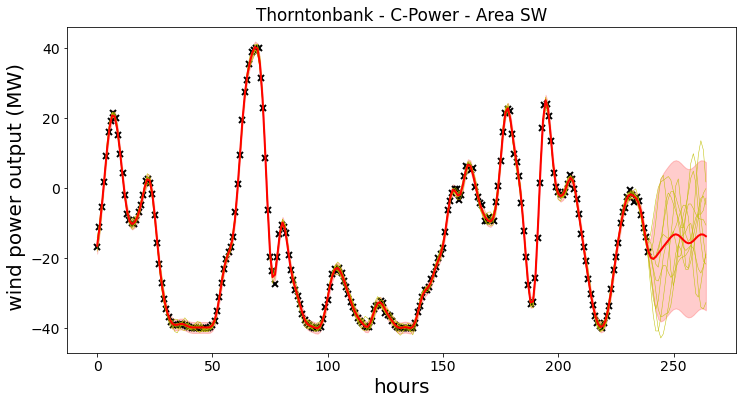

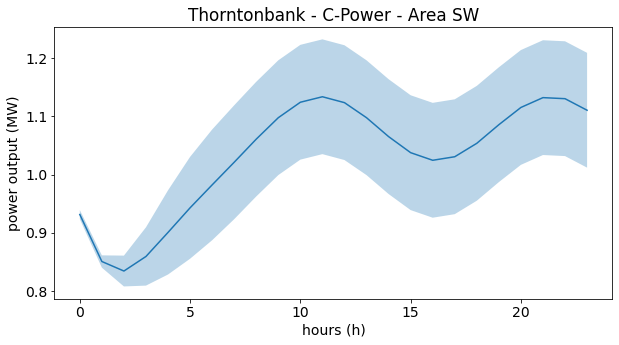

In [34]:
key = 'BLLA-1' # wind generation
key = 'BABAW-1'
key = 'BOWLW-1'
key = 'Northwind'
key = 'Belwind Phase 1' # load
key = 'Seastar Offshore WP' # load
key = 'GYMRO-15'
key = 'UP_BDDSLDSRDI_1'
key = 'Thorntonbank - C-Power - Area NE'
key = 'Thorntonbank - C-Power - Area SW'

T_horizon = 24

m, L, C = pipeline(df, T_horizon, key, kernel, PLOT_TS=False, PLOT_GPR=True, PLOT_PRED=True, SAVE=False)

### All

BABAW-1


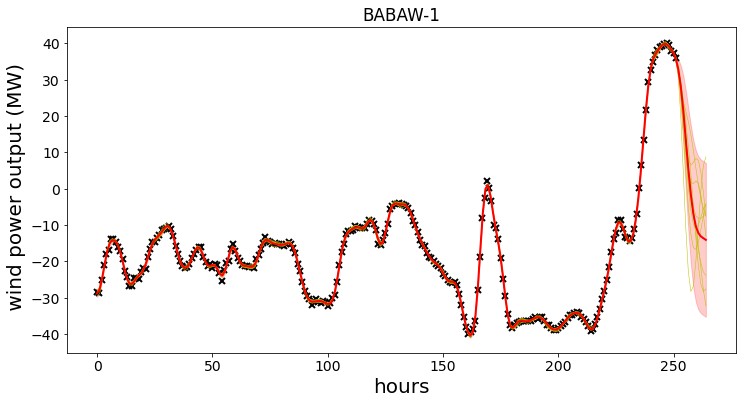

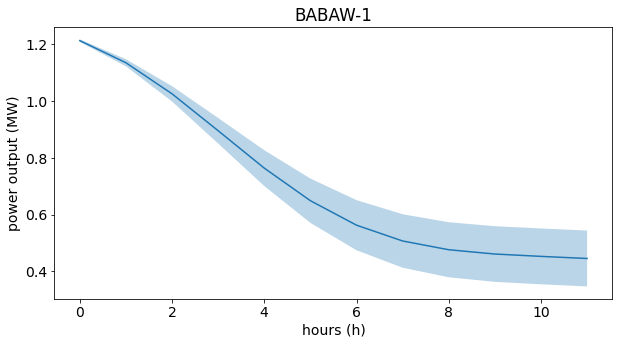

BLLA-1


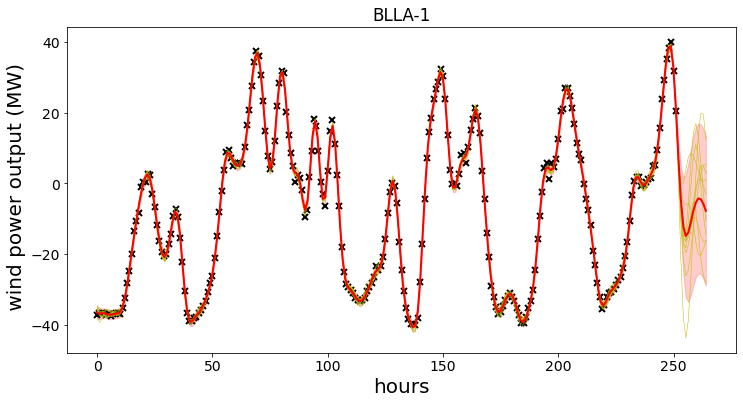

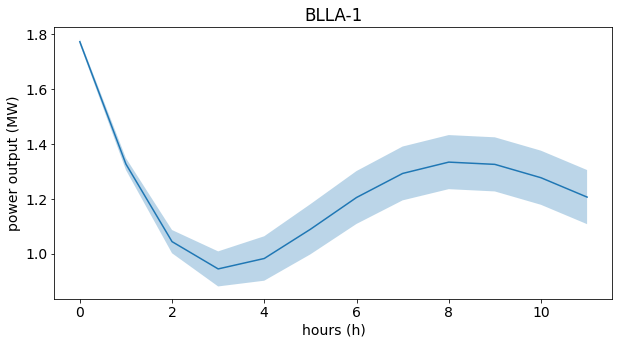

BOWLW-1


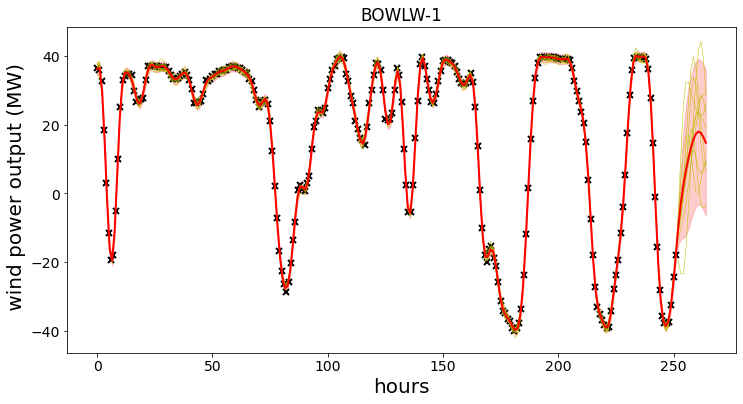

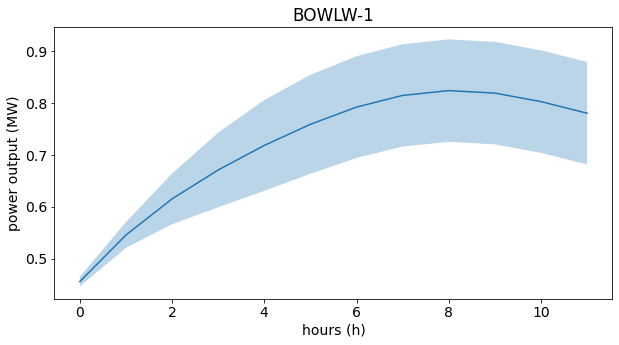

Northwind


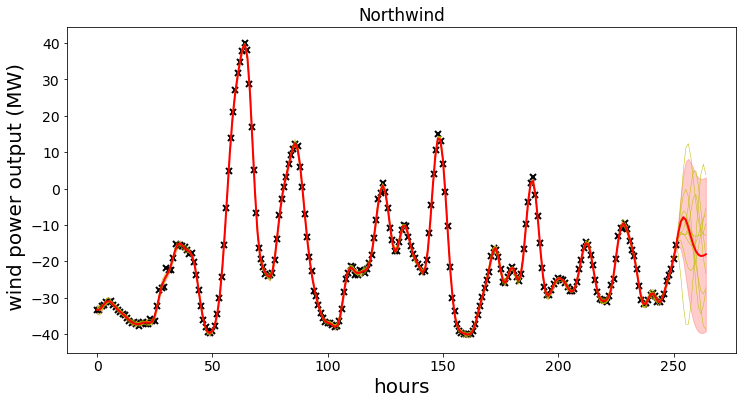

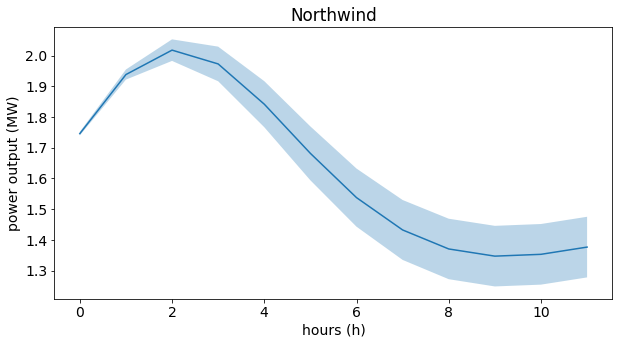

Belwind Phase 1


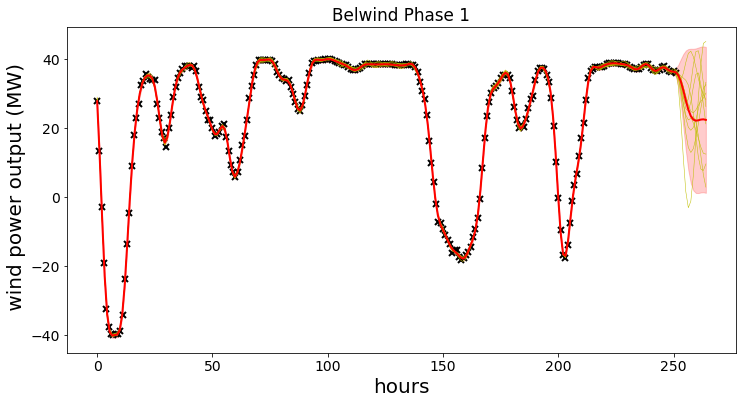

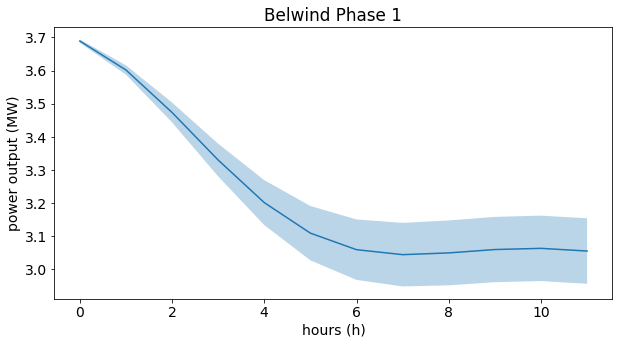

Seastar Offshore WP


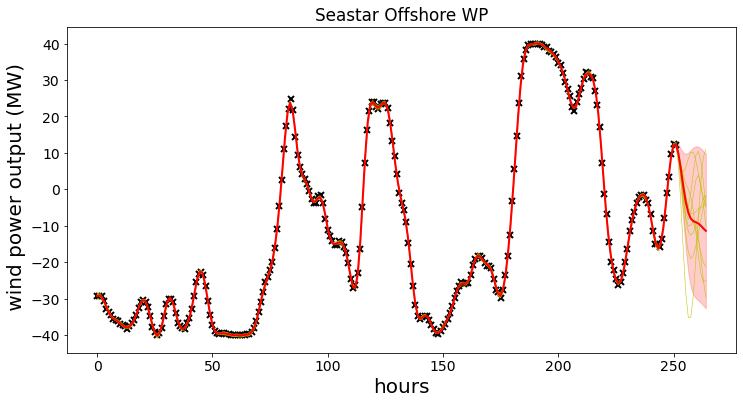

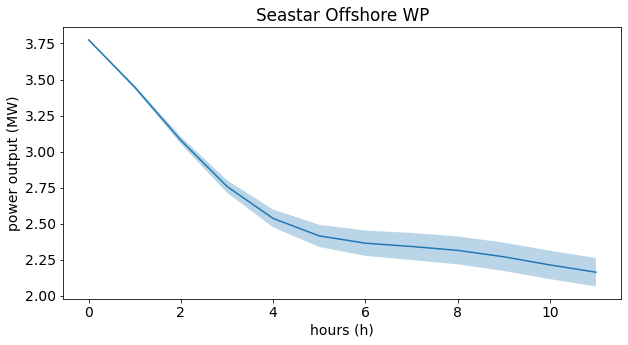

GYMRO-15


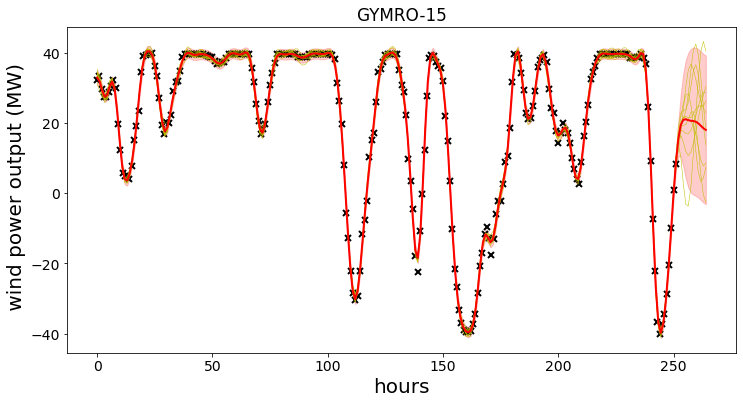

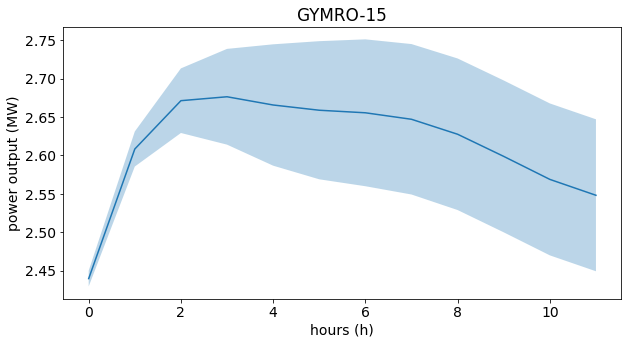

UP_BDDSLDSRDI_1


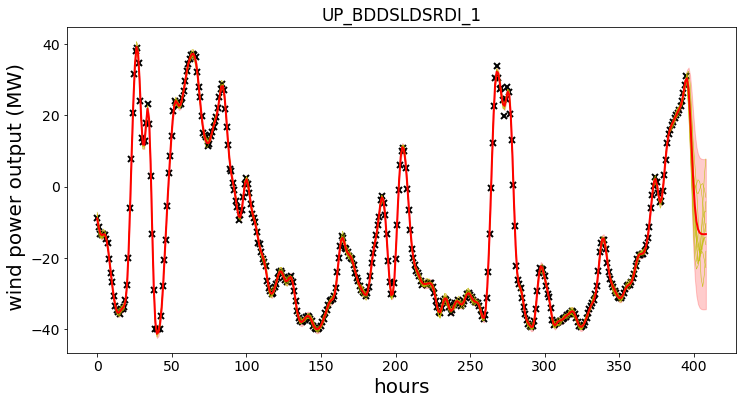

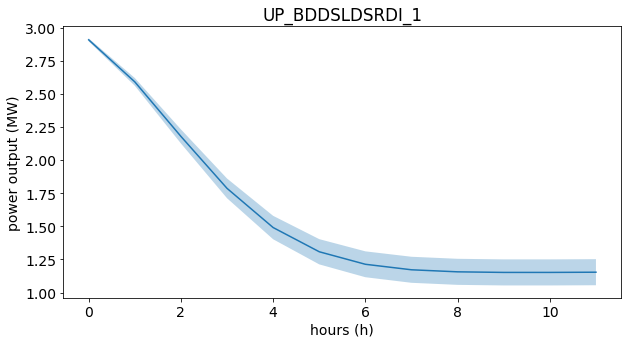

Thorntonbank - C-Power - Area NE


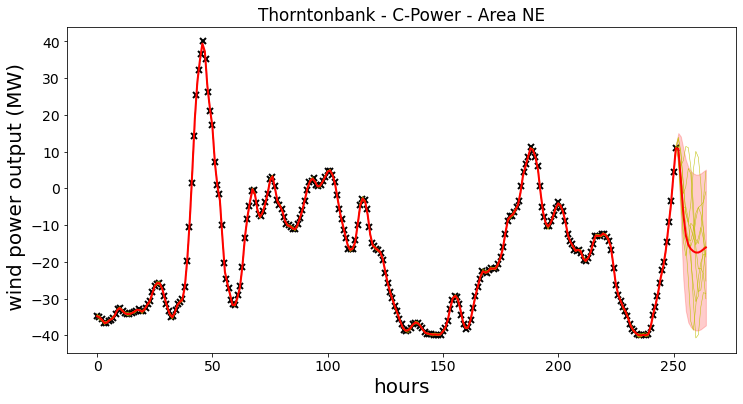

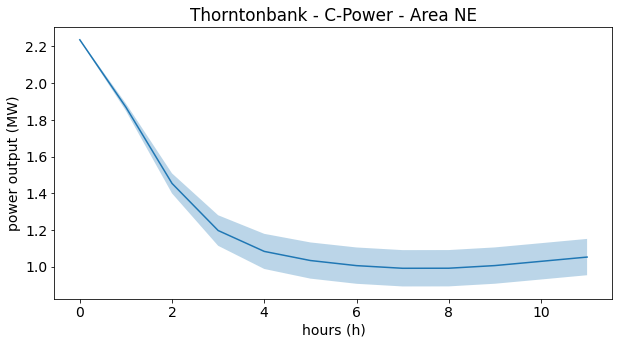

Thorntonbank - C-Power - Area SW


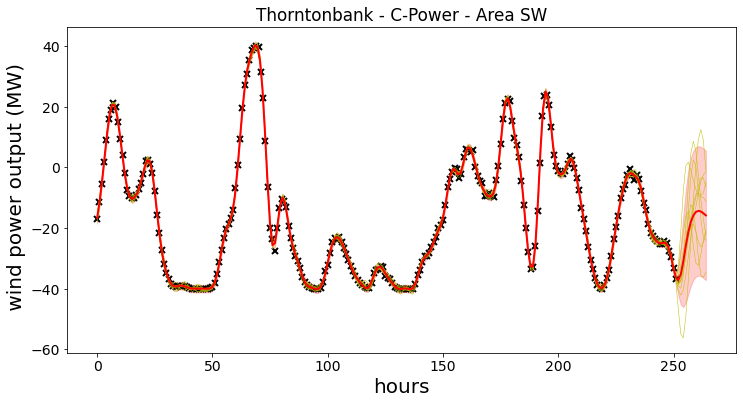

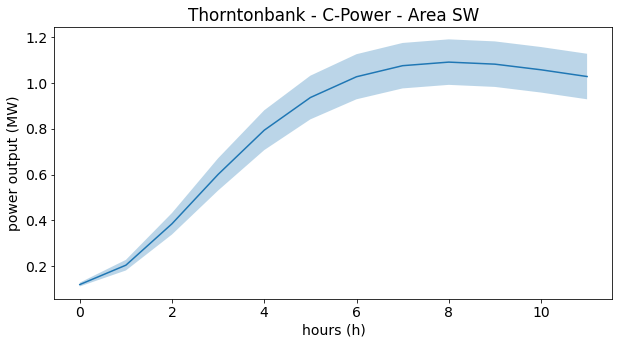

In [35]:
# all at once
T_horizon = 12
for key in params.keys():
    print(key)
    _,_,_ = pipeline(df, T_horizon, key, kernel, PLOT_TS=False, PLOT_GPR=True, PLOT_PRED=True, SAVE=False)

BABAW-1


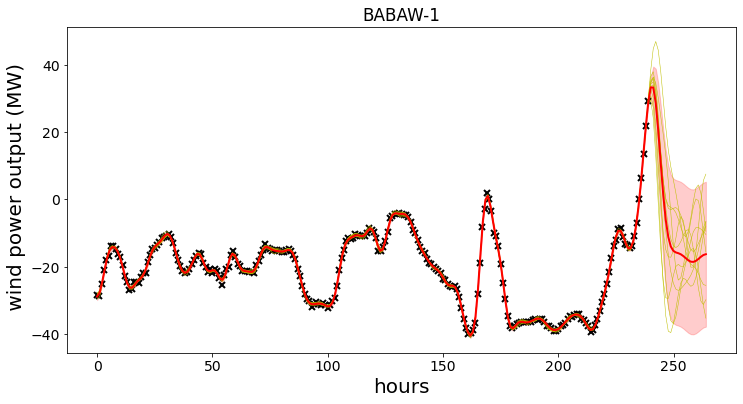

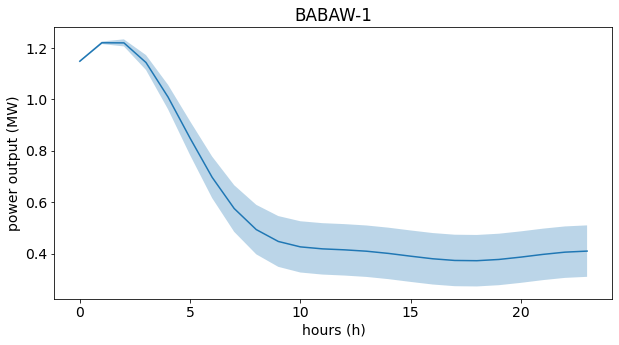

Successfully stored load data!!
BLLA-1


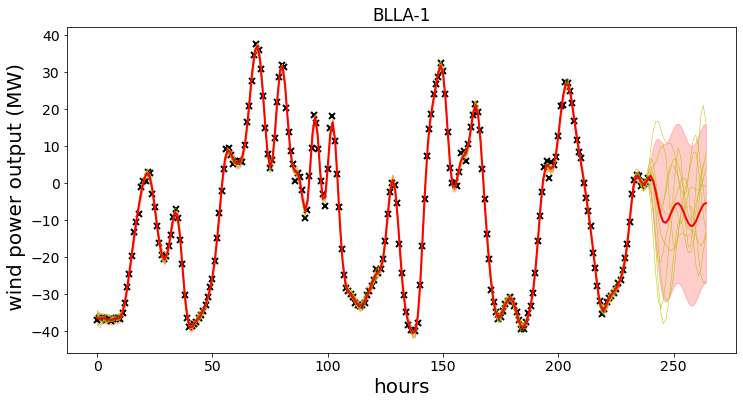

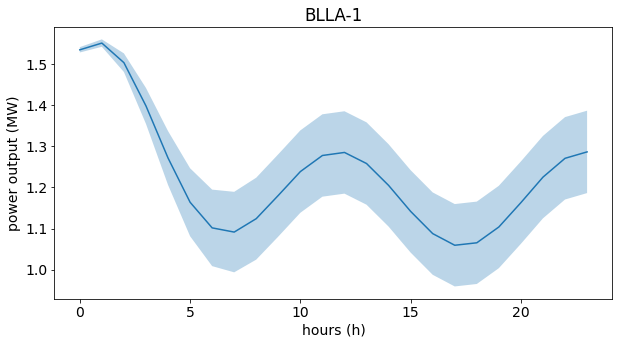

Successfully stored load data!!
BOWLW-1


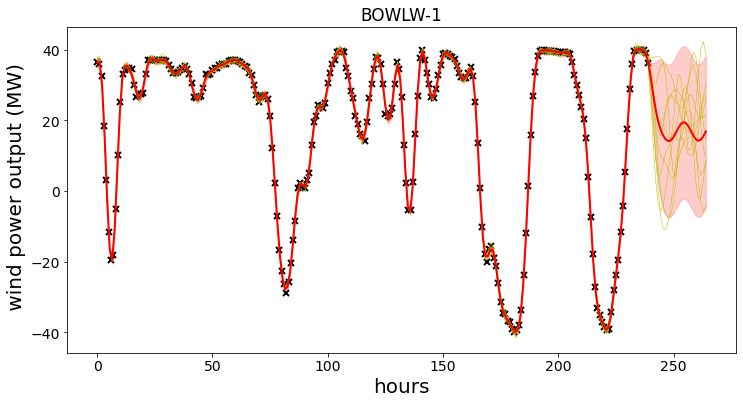

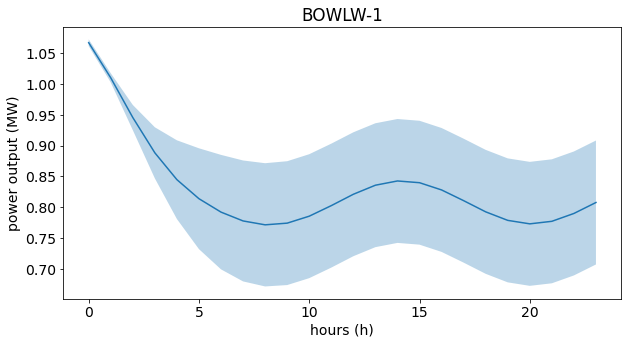

Successfully stored load data!!
Northwind


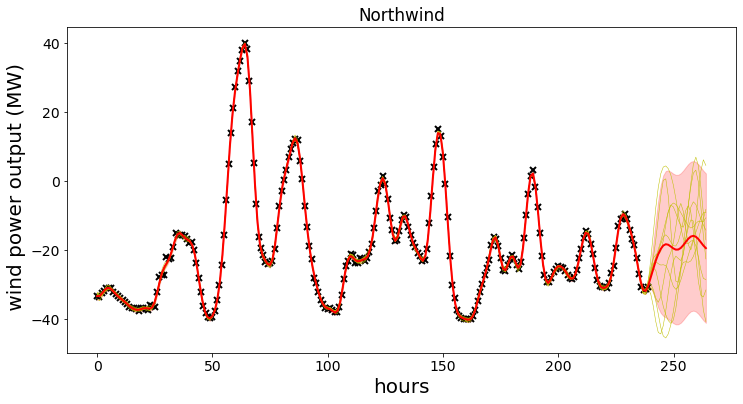

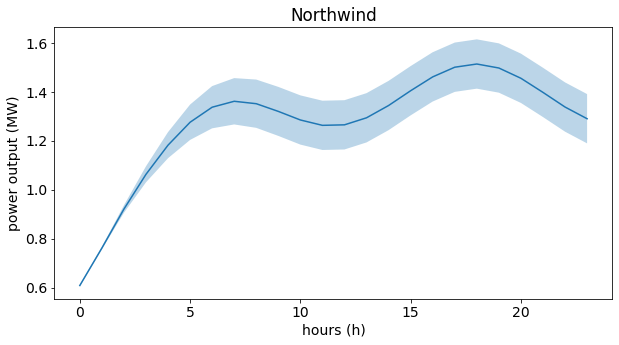

Successfully stored load data!!
Belwind Phase 1


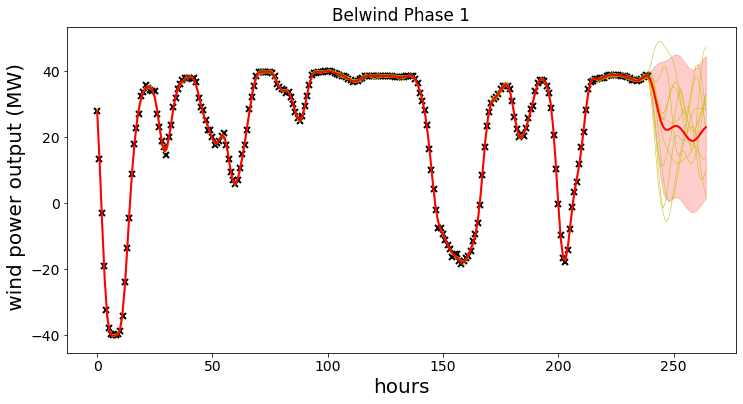

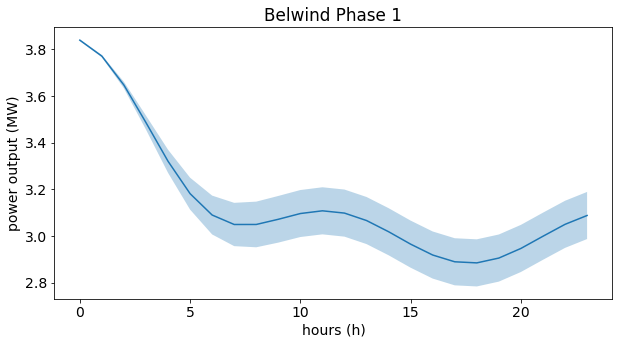

Successfully stored load data!!
Seastar Offshore WP


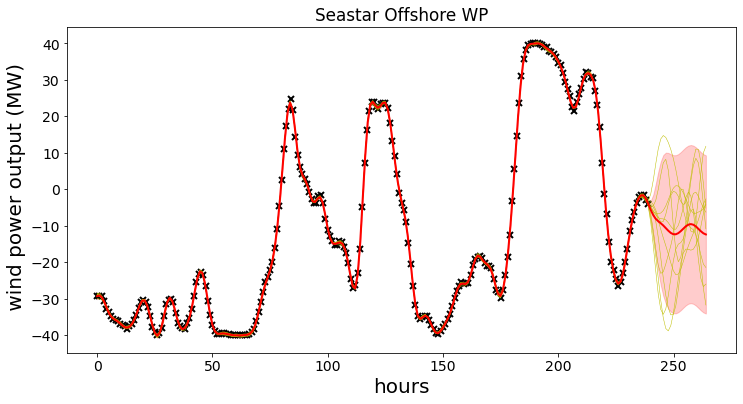

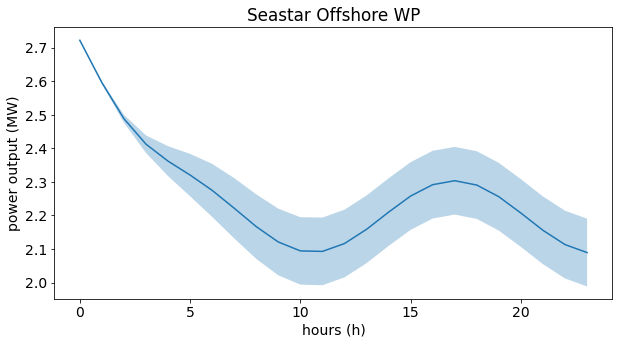

Successfully stored load data!!
GYMRO-15


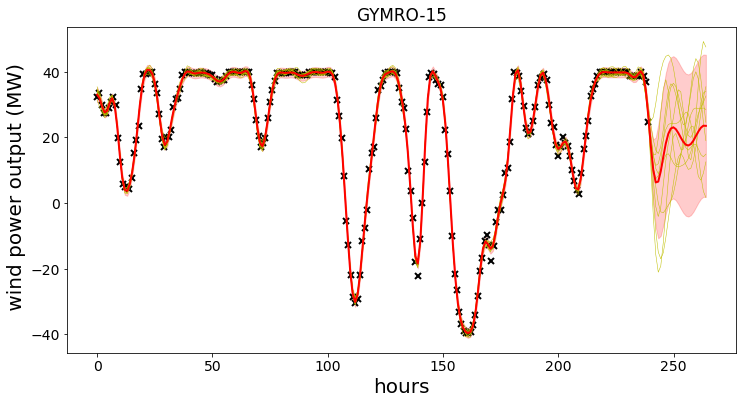

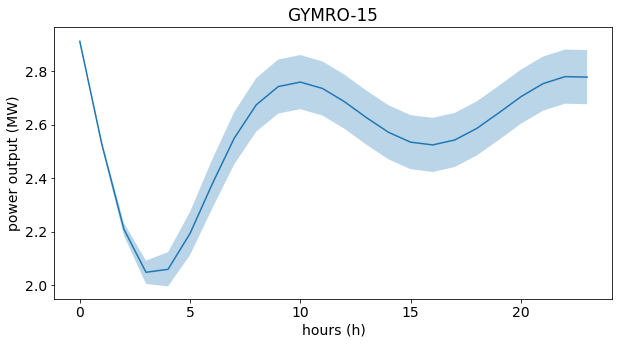

Successfully stored load data!!
UP_BDDSLDSRDI_1


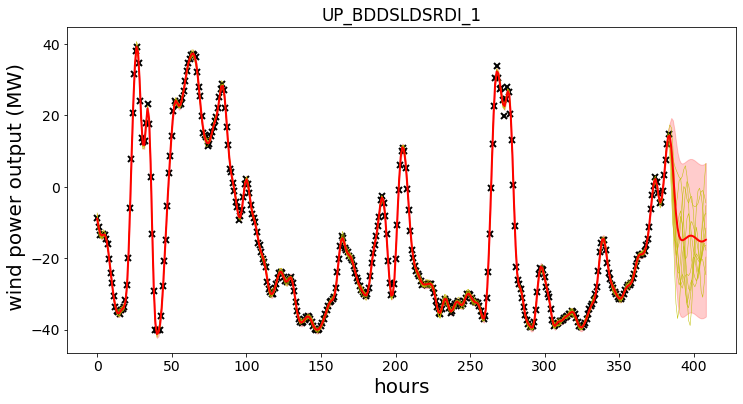

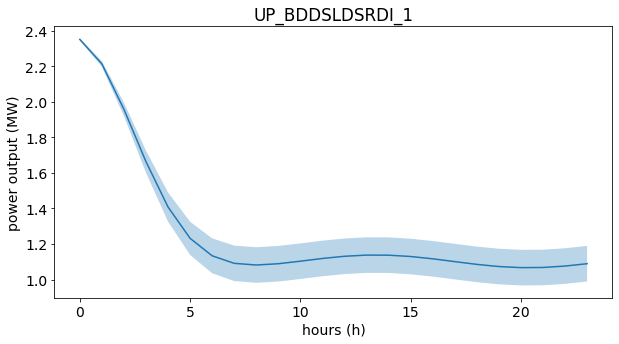

Successfully stored load data!!
Thorntonbank - C-Power - Area NE


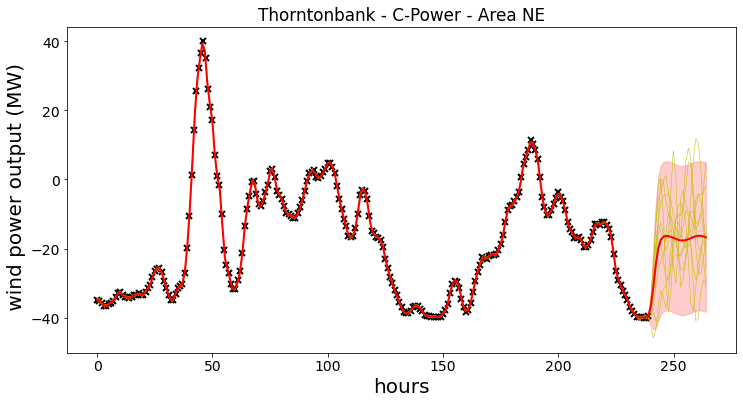

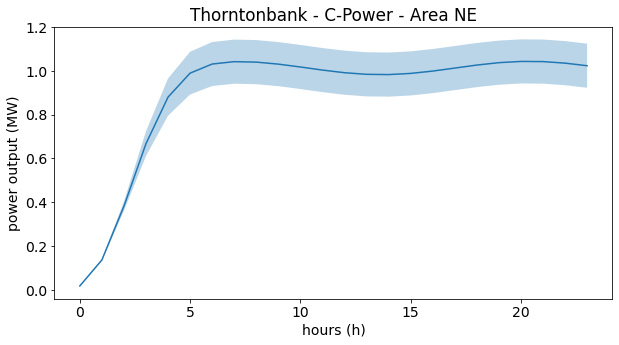

Successfully stored load data!!
Thorntonbank - C-Power - Area SW


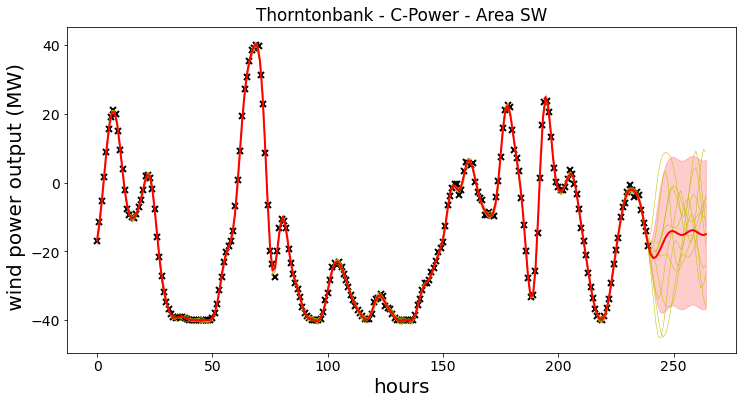

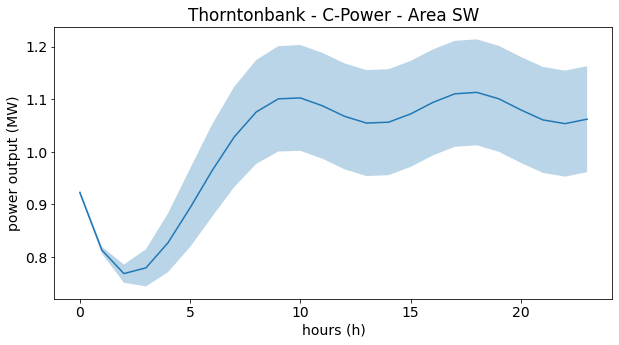

Successfully stored load data!!


In [37]:
# all at once
T_horizon = 24
for key in params.keys():
    print(key)
    _,_,_ = pipeline(df, T_horizon, key, kernel, PLOT_TS=False, PLOT_GPR=True, PLOT_PRED=True, SAVE=True)

## Scaling

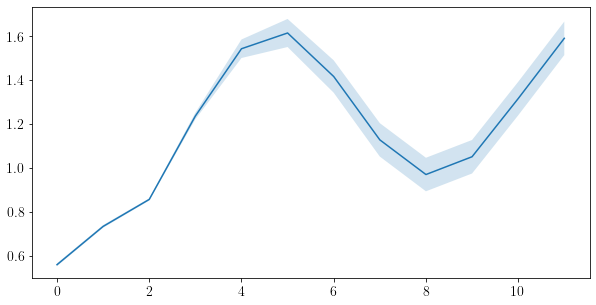

In [171]:
# scaling
i = '1'
name = 'LoadData_test_cov_volatile_unc_'+str(i)
mat = scipy.io.loadmat('data/'+name+'.mat')
mu = mat['mu_post']
var = mat['cov']
L_post = mat['Lpost']

mu = np.squeeze(mu)
var_diag = np.sqrt(np.diag(var))

plt.figure(figsize=(10,5))
plt.plot(mu)
plt.fill_between(range(len(mu)), mu+var_diag, mu-var_diag, alpha=0.2)
plt.show()

#name = 'LoadData_test_cov_volatile_unc_'+str(i)
#to_mat_cov(L, var, mu, output_name=name)